# Project 2: South African Heart Disease

Group 22


In [1]:
import pandas as pd
import numpy as np

from collections import Counter
from sklearn.preprocessing import StandardScaler
from scipy.linalg import svd

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, plot, xlabel, ylabel, legend, show, clim, semilogx, loglog, title, subplot, grid
from scipy.io import loadmat

import sklearn.linear_model as lm
from sklearn.linear_model import Ridge, LinearRegression, LogisticRegression
from sklearn import model_selection, tree
from scipy import stats
import scipy.stats as st
import torch

from toolbox_02450 import feature_selector_lr, bmplot, rlr_validate, train_neural_net

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# Load data from csv and store it in dataframe
path = 'C:/Users/HP/Desktop/MASTER/1ST COURSE/INTRO TO ML AND DM/South-African-Heart-Disease-data-analysis-using-python-master/part1/dataset.xls'
df = pd.read_excel(path, sheet_name='Sheet1')

## Data visualization

In [3]:
# Change variables to integers: Replace absent and present by 0 and 1
df = df.replace('Absent',0)
df = df.replace('Present',1)
df

,row,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1,160,12.00,5.73,23.11,1,49,25.30,97.20,52,1
1,2,144,0.01,4.41,28.61,0,55,28.87,2.06,63,1
2,3,118,0.08,3.48,32.28,1,52,29.14,3.81,46,0
3,4,170,7.50,6.41,38.03,1,51,31.99,24.26,58,1
4,5,134,13.60,3.50,27.78,1,60,25.99,57.34,49,1
...,...,...,...,...,...,...,...,...,...,...,...
457,459,214,0.40,5.98,31.72,0,64,28.45,0.00,58,0
458,460,182,4.20,4.41,32.10,0,52,28.61,18.72,52,1
459,461,108,3.00,1.59,15.23,0,40,20.09,26.64,55,0
460,462,118,5.40,11.61,30.79,0,64,27.35,23.97,40,0


In [4]:
# Drop row column
df.drop(['row'], axis = 'columns', inplace=True) 

In [5]:
# Create matrix with values
raw_data = df.values  
cols = range(0, 9) 
X = raw_data[:, cols]
X = np.asarray(X, dtype = np.intc)
attributeNames = np.asarray(df.columns[cols])
classLabels = raw_data[:,-1]
classNames = sorted(set(classLabels))
classDict = dict(zip(classNames,range(len(classNames))))
y = np.array([classDict[cl] for cl in classLabels])
N, M = X.shape
C = len(classNames)

### Dependent variable

Which attribute is the best suitable for regression analysis? 

We use OLS linear regression model. We select one variable to be predicted according to all our other variables in the dataset, and measure the values of the MSE residuals when plotting the estimated data points against the true line of fitting.

Average MSE of sbp: 4.921508126476884e-15
Average MSE of tobacco: 2.5376526277146434e-16
Average MSE of ldl: -5.767392335715099e-16
Average MSE of adiposity: -2.0608815279621954e-15
Average MSE of typea: 2.3377163600765202e-15
Average MSE of obesity: -1.937843824800273e-15
Average MSE of alcohol: -6.890111377067638e-15
Average MSE of age: -9.535421995048964e-16


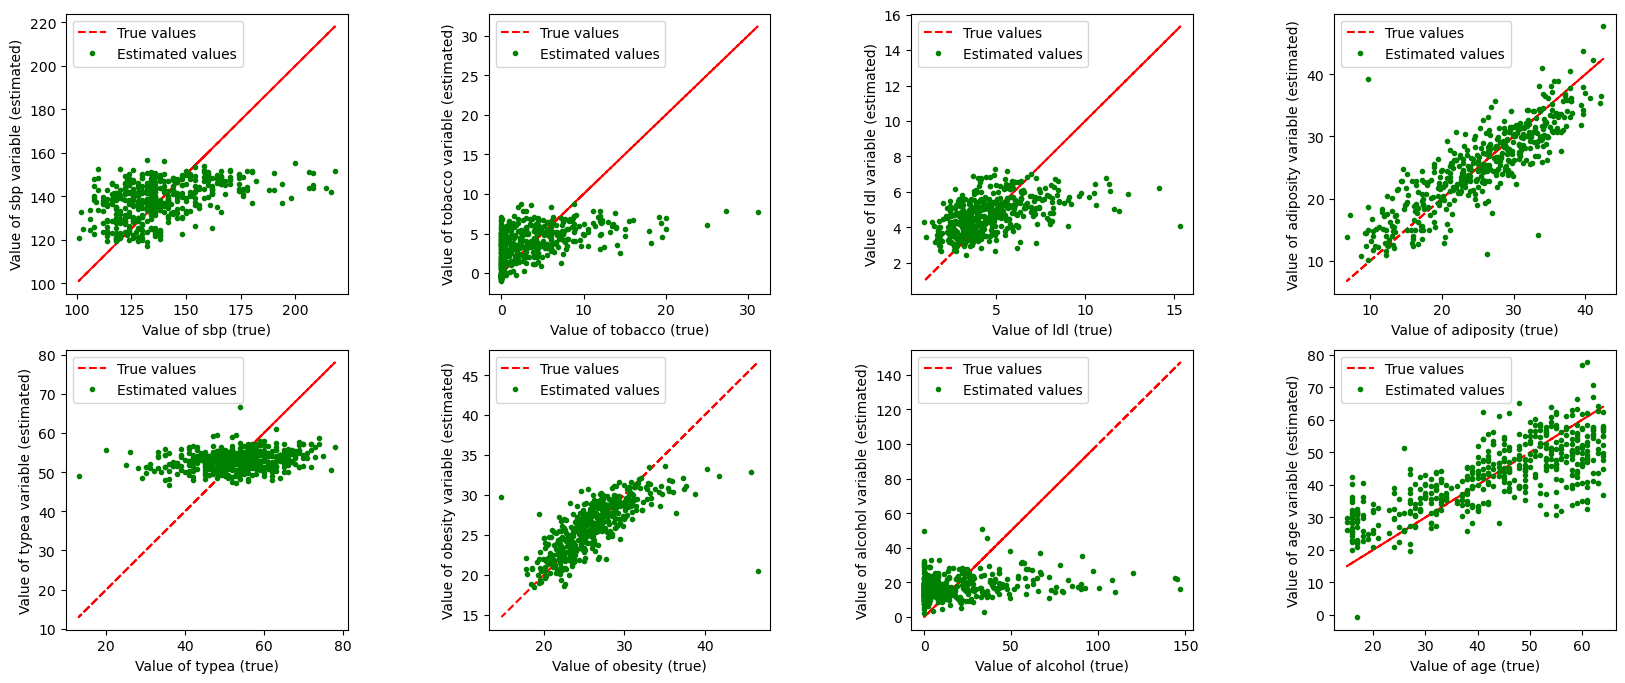

In [10]:
from numpy import mean
criterion_variables = ['sbp', 'tobacco', 'ldl', 'adiposity', 'typea', 'obesity', 'alcohol', 'age']

# Display plot
plt.figure(figsize=(20,8))
plt.subplots_adjust(wspace = 0.5)

for i in range(8):
    attr_col = list(df.columns).index(criterion_variables[i])
    cols = list(range(0, attr_col)) + list(range(attr_col + 1, len(df.columns)))

    X = raw_data[:, cols]
    y = raw_data[:, attr_col] # the 'oldpeak' column
    attributeNames = list(df.columns[cols])

    N, M = X.shape
    
    X = stats.zscore(X);

    # Fit ordinary least squares regression model    
    model = lm.LinearRegression()
    model.fit(X,y)

    # Predict thalach
    y_est = model.predict(X)
    residual = y_est-y
    #res = [abs(ele) for ele in residual]
    print(f'Average MSE of {criterion_variables[i]}: {mean(residual)}')
    
    plt.subplot(2, 4, i+1)
    plt.plot(y, y, '--r')
    plt.plot(y, y_est, '.g')
    plt.xlabel('Value of {0} (true)'.format(criterion_variables[i])); ylabel('Value of {0} variable (estimated)'.format(criterion_variables[i]))
    plt.legend(['True values', 'Estimated values'], loc = 2);


Estimation values of ‘adiposity’, ‘obesity’, and 'age' seem to align well with the line of true fit. However ‘**obesity**’ has lower average MSE residuals overall, so we will choose it as our dependent variable to be estimated using all other dataset attributes.

###  Feature selection

Can we improve the model by reaching the same prediction power using fewer attributes?

We use feature forward selection with cross-validation across 10 outer folds and 10 inner folds, where we train a model starting with no features and gradually select and add, one-by-one, the features which minimize the squared error in the inner cross-validation loop, until the error cannot be minimized by adding any further predictors. Finally, we compute the R2 value of both the full model without feature selection and the newly-fitted feature-selecting model upon a test set, in order to see what percentage of the variance within the dataset is explained by each model.

Linear regression without feature selection:
- Training error: 7.676181500719773
- Test error:     8.089202212000334
- R^2 train:     0.5666310034378158
- R^2 test:     0.5352290249761761


Linear regression with feature selection:
- Training error: 7.751710357957042
- Test error:     8.082125826276371
- R^2 train:     0.5623669217366035
- R^2 test:     0.5356356038459306


Text(0, 0.5, 'Attribute')

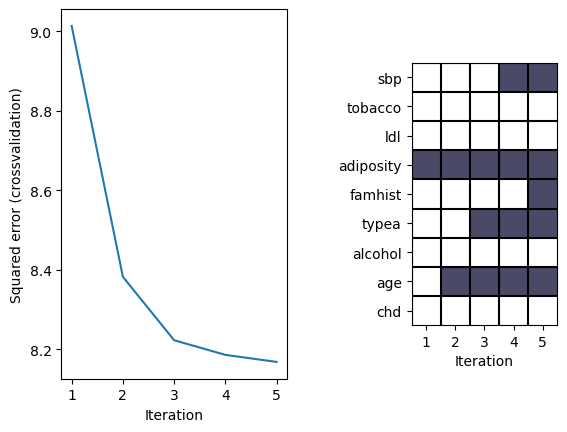

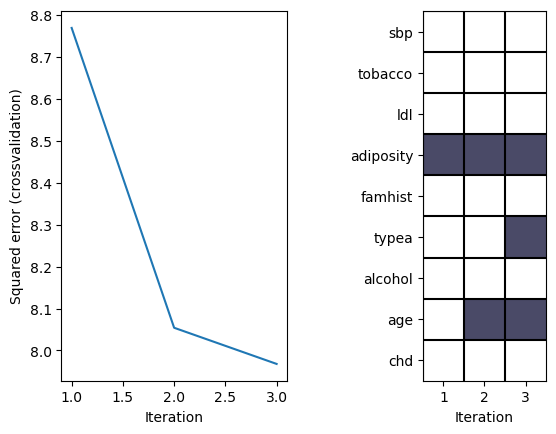

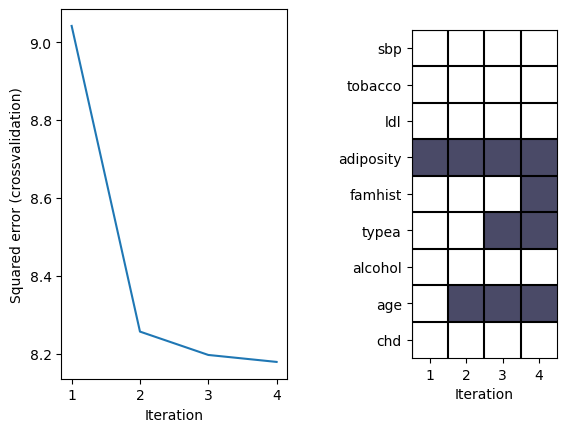

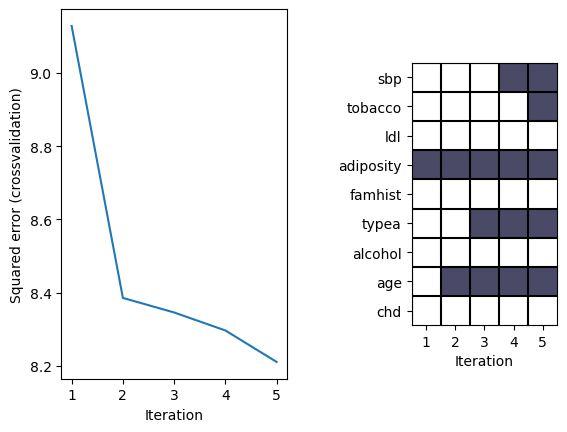

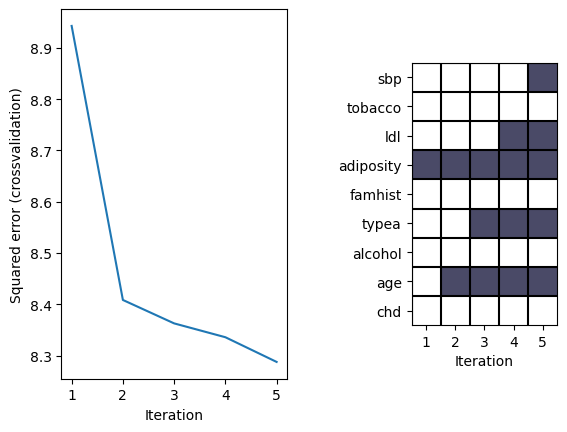

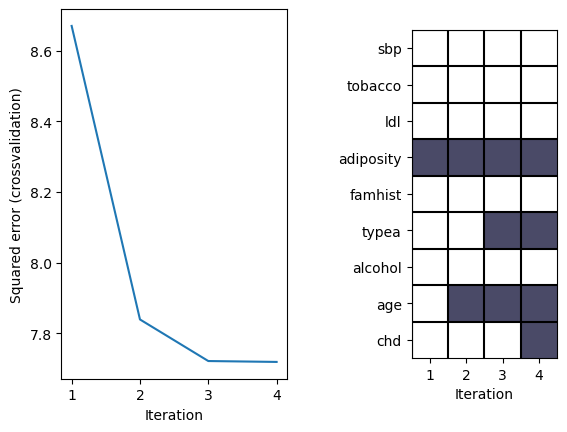

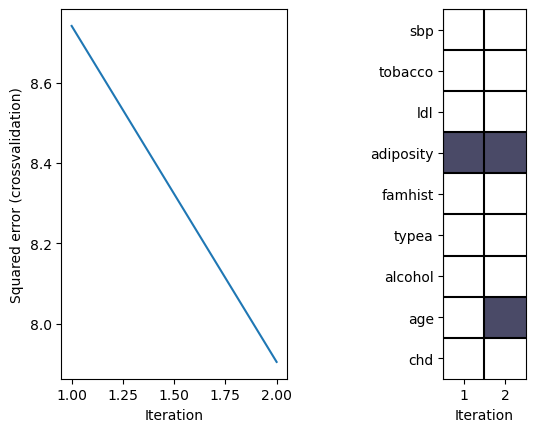

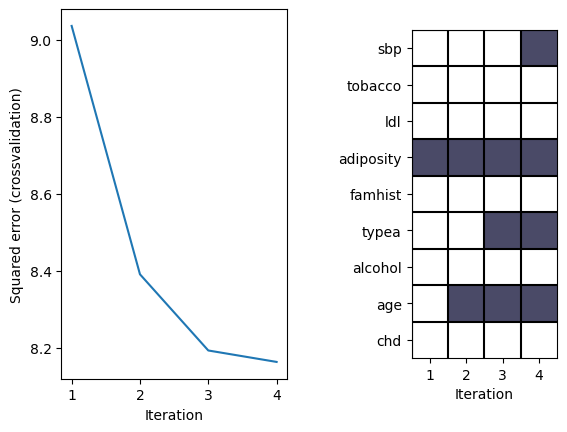

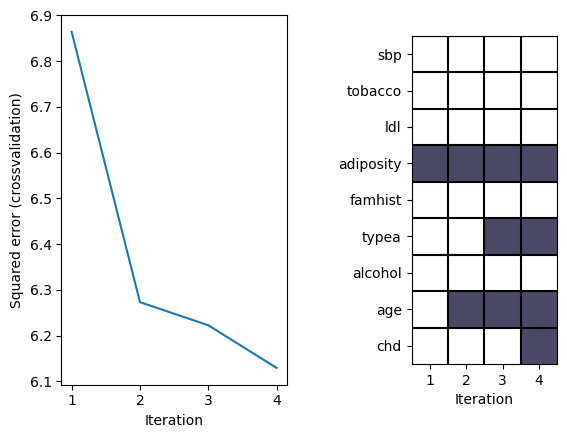

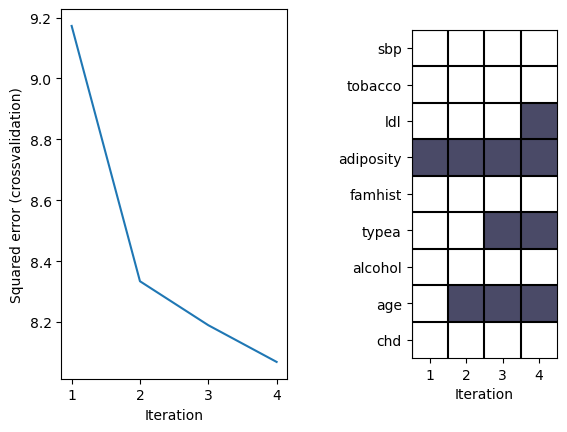

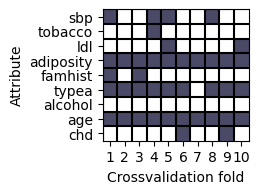

In [11]:
raw_data = df.to_numpy()
attr_col = list(df.columns).index('obesity')
cols = list(range(0, attr_col)) + list(range(attr_col + 1, len(df.columns)))

X = raw_data[:, cols]
y = raw_data[:, attr_col] # the 'adiposity' column
attributeNames = list(df.columns[cols])
N, M = X.shape

X = stats.zscore(X)

## Crossvalidation
# Create crossvalidation partition for evaluation
K = 10
CV = model_selection.KFold(n_splits=K,shuffle=True)

# Initialize variables
Features = np.zeros((M,K))
Error_train = np.empty((K,1))
Error_test = np.empty((K,1))
Error_train_fs = np.empty((K,1))
Error_test_fs = np.empty((K,1))
Error_train_nofeatures = np.empty((K,1))
Error_test_nofeatures = np.empty((K,1))

k=0
for train_index, test_index in CV.split(X):
    
    # extract training and test set for current CV fold
    X_train = X[train_index,:]
    y_train = y[train_index]
    X_test = X[test_index,:]
    y_test = y[test_index]
    internal_cross_validation = 10
    
    # Compute squared error without using the input data at all
    Error_train_nofeatures[k] = np.square(y_train-y_train.mean()).sum()/y_train.shape[0]
    Error_test_nofeatures[k] = np.square(y_test-y_test.mean()).sum()/y_test.shape[0]

    # Compute squared error with all features selected (no feature selection)
    m = lm.LinearRegression(fit_intercept=True).fit(X_train, y_train)
    Error_train[k] = np.square(y_train-m.predict(X_train)).sum()/y_train.shape[0]
    Error_test[k] = np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0]

    # Compute squared error with feature subset selection
    textout = ''
    selected_features, features_record, loss_record = feature_selector_lr(X_train, y_train, internal_cross_validation,display=textout)
    
    Features[selected_features,k] = 1
    # .. alternatively you could use module sklearn.feature_selection
    
    if len(selected_features) == 0:
        print('No features were selected, i.e. the data (X) in the fold cannot describe the outcomes (y).' )
    else:
        m = lm.LinearRegression(fit_intercept=True).fit(X_train[:,selected_features], y_train)
        Error_train_fs[k] = np.square(y_train-m.predict(X_train[:,selected_features])).sum()/y_train.shape[0]
        Error_test_fs[k] = np.square(y_test-m.predict(X_test[:,selected_features])).sum()/y_test.shape[0]
    
        figure(k)
        subplot(1,2,1)
        plot(range(1,len(loss_record)), loss_record[1:])
        xlabel('Iteration')
        ylabel('Squared error (crossvalidation)')    
        
        subplot(1,3,3)
        bmplot(attributeNames, range(1,features_record.shape[1]), -features_record[:,1:])
        clim(-1.5,0)
        xlabel('Iteration')

    #print('Cross validation fold {0}/{1}'.format(k+1,K))
    #print('Train indices: {0}'.format(train_index))
    #print('Test indices: {0}'.format(test_index))
    #print('Features no: {0}\n'.format(selected_features.size))

    k+=1
    
# Display results
print('Linear regression without feature selection:')
print('- Training error: {0}'.format(Error_train.mean()))
print('- Test error:     {0}'.format(Error_test.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}'.format((Error_test_nofeatures.sum()-Error_test.sum())/Error_test_nofeatures.sum()))
print('\n')
print('Linear regression with feature selection:')
print('- Training error: {0}'.format(Error_train_fs.mean()))
print('- Test error:     {0}'.format(Error_test_fs.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train_fs.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}'.format((Error_test_nofeatures.sum()-Error_test_fs.sum())/Error_test_nofeatures.sum()))

figure(k)
subplot(1,3,2)
bmplot(attributeNames, range(1,Features.shape[1]+1), -Features)
clim(-1.5,0)
xlabel('Crossvalidation fold')
ylabel('Attribute')

From the forward selection algorithm, we can see that our dependent variable ‘obesity’ is best described using the features: ‘adiposity’, 'typea' and ‘age’, while many other variables have been left out completely from our model, due to the low assistance in further reducing the MSE of the estimates. 

However, as can be seen in the table, the R2 value in the test set of both models is similar, representing a variance of ~54\%, suggesting that feature selection does not have an optimising impact on our regression model, and may even slightly increase the MSE. This means that, although the criterion is largely predicted by only a few attributes, the full model definitely does not over-fit the data and even terms that have a very low correlation will help to reduce the MSE.

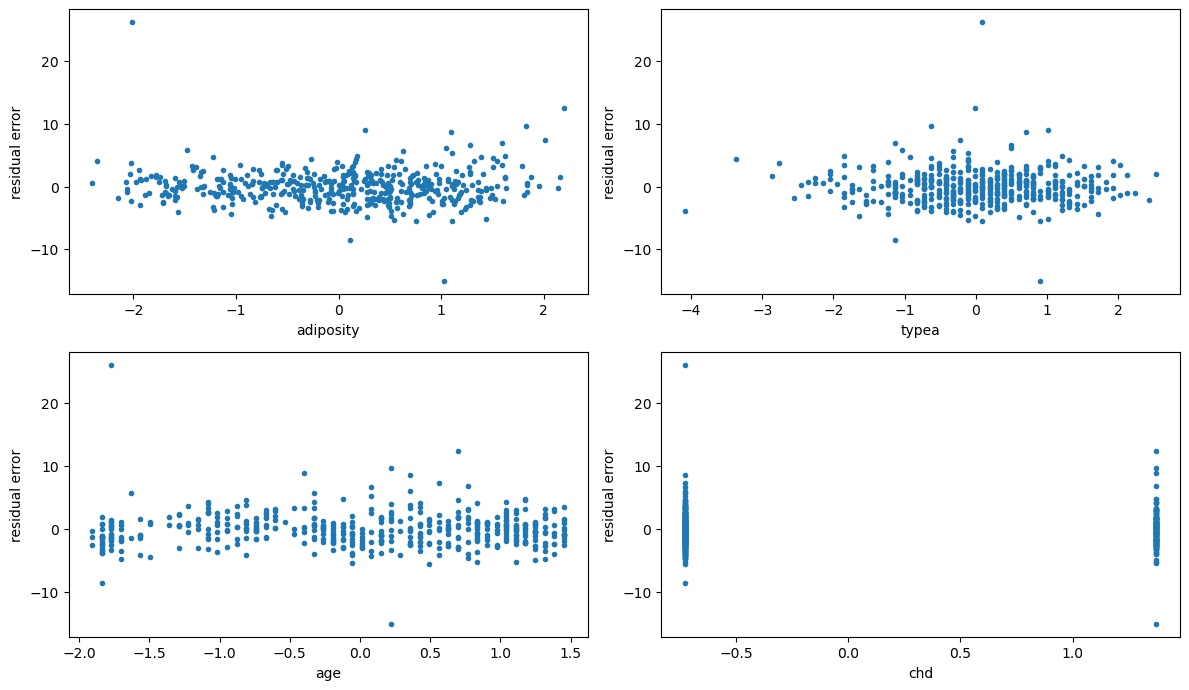

In [8]:
# Inspect selected feature coefficients effect on the entire dataset and plot the fitted model residual error 
# as function of each attribute to inspect for systematic structure in the residual

f=1 # cross-validation fold to inspect
ff=Features[:,f-1].nonzero()[0]
if len(ff) == 0:
    print('\nNo features were selected, i.e. the data (X) in the fold cannot describe the outcomes (y).' )
else:
    m = lm.LinearRegression(fit_intercept=True).fit(X[:,ff], y)
    
    y_est= m.predict(X[:,ff])
    residual=y-y_est
    
    figure(k+1, figsize=(12,10))
    title('Residual error vs. Attributes for features selected in cross-validation fold {0}'.format(f))
    
    for i in range(0,len(ff)):
        subplot(3, int( np.ceil(len(ff) // 2)),i+1)
        plot(X[:,ff[i]],residual,'.')
        xlabel(attributeNames[ff[i]])
        ylabel('residual error')
    plt.tight_layout()
    
show()

### Regularization

Here we introduce a regularization parameter **λ** into the linear regression, which will take values between $10^-3$ and $10^7$ because we want to obtain the lowest possible generalization error when using our linear regression model.

In order to reliably estimate the generalization error for different values of λ, we have performed two-level cross-validation testing, with the outer layer having K1 = 10 folds and the inner fold being selected to K2 = 10 folds.

In [9]:
# Add offset attribute
X = np.concatenate((np.ones((X.shape[0],1)),X),1)
attributeNames= [u'Offset']+attributeNames
M = M+1
attributeNames

['Offset',
 'sbp',
 'tobacco',
 'ldl',
 'adiposity',
 'famhist',
 'typea',
 'alcohol',
 'age',
 'chd']

<Figure size 640x480 with 0 Axes>

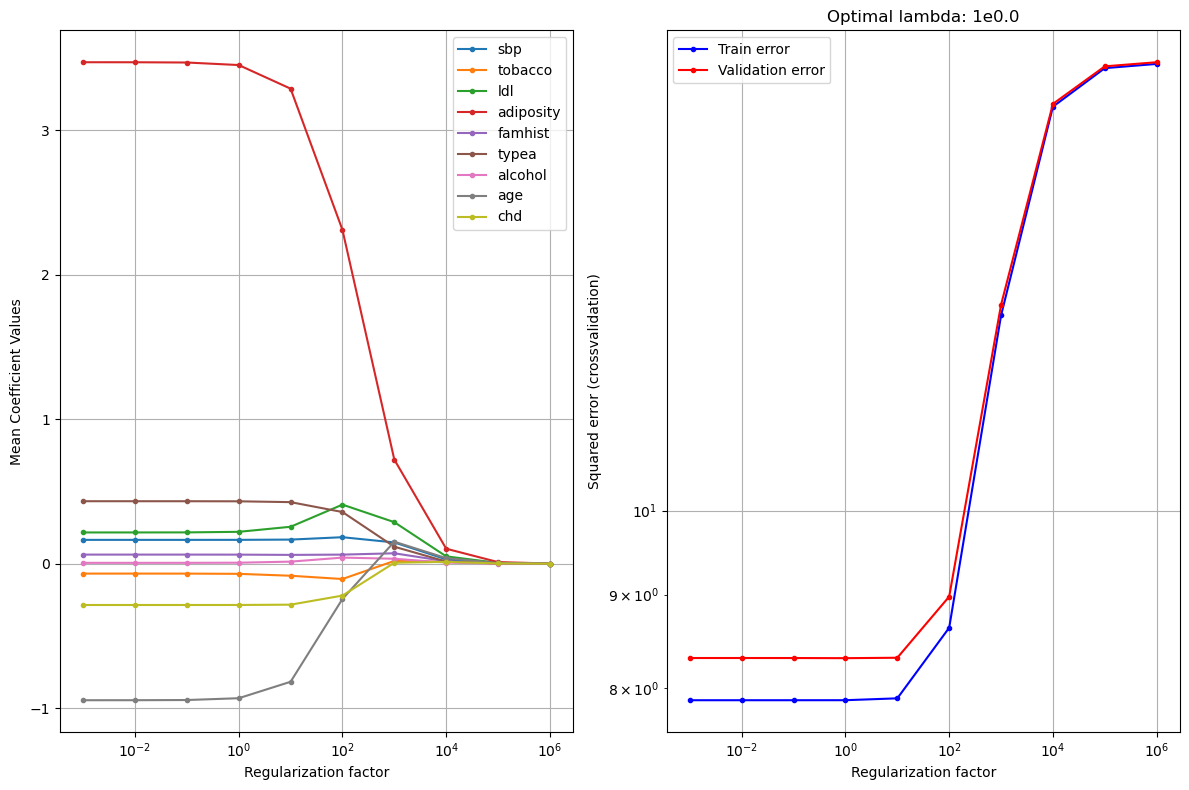

Linear regression without feature selection:
- Training error: 7.673983419360837
- Test error:     8.129022446123653
- R^2 train:     0.5667714948502792
- R^2 test:     0.5343423323456674

Regularized linear regression:
- Training error: 7.674173495819484
- Test error:     8.128162255884462
- R^2 train:     0.5667607642380869
- R^2 test:     0.5343916069273499

Weights in last fold:
         Offset           25.99
            sbp            0.16
        tobacco           -0.07
            ldl            0.22
      adiposity            3.45
        famhist            0.06
          typea            0.43
        alcohol            0.01
            age           -0.93
            chd           -0.29
Generalization error for different values of lambda:
               0.001                 8.04
                0.01                 8.04
                 0.1                 8.04
                 1.0                 8.04
                10.0                 8.05
               100.0           

In [10]:
## Crossvalidation
# Create crossvalidation partition for evaluation
K = 10
CV = model_selection.KFold(K, shuffle=True)
#CV = model_selection.KFold(K, shuffle=False)

# Values of lambda
lambdas = np.power(10.,range(-3,7))

# Initialize variables
#T = len(lambdas)
Error_train = np.empty((K,1))
Error_test = np.empty((K,1))
Error_train_rlr = np.empty((K,1))
Error_test_rlr = np.empty((K,1))
Error_train_nofeatures = np.empty((K,1))
Error_test_nofeatures = np.empty((K,1))
val_error_lambdas = np.empty((K,len(lambdas)))
w_rlr = np.empty((M,K))
mu = np.empty((K, M-1))
sigma = np.empty((K, M-1))
w_noreg = np.empty((M,K))

k=0
for train_index, test_index in CV.split(X,y):
    
    # extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    internal_cross_validation = 10    
    
    opt_val_err, opt_lambda, mean_w_vs_lambda, train_err_vs_lambda, test_err_vs_lambda = rlr_validate(X_train, y_train, lambdas, internal_cross_validation)
    val_error_lambdas[k] = test_err_vs_lambda
    
    # Standardize outer fold based on training set, and save the mean and standard
    # deviations since they're part of the model (they would be needed for
    # making new predictions) - for brevity we won't always store these in the scripts
    mu[k, :] = np.mean(X_train[:, 1:], 0)
    sigma[k, :] = np.std(X_train[:, 1:], 0)
    
    X_train[:, 1:] = (X_train[:, 1:] - mu[k, :] ) / sigma[k, :] 
    X_test[:, 1:] = (X_test[:, 1:] - mu[k, :] ) / sigma[k, :] 
    
    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train
    
    # Compute mean squared error without using the input data at all
    Error_train_nofeatures[k] = np.square(y_train-y_train.mean()).sum(axis=0)/y_train.shape[0]
    Error_test_nofeatures[k] = np.square(y_test-y_test.mean()).sum(axis=0)/y_test.shape[0]

    # Estimate weights for the optimal value of lambda, on entire training set
    lambdaI = opt_lambda * np.eye(M)
    lambdaI[0,0] = 0 # Do no regularize the bias term
    w_rlr[:,k] = np.linalg.solve(XtX+lambdaI,Xty).squeeze()
    # Compute mean squared error with regularization with optimal lambda
    Error_train_rlr[k] = np.square(y_train-X_train @ w_rlr[:,k]).sum(axis=0)/y_train.shape[0]
    Error_test_rlr[k] = np.square(y_test-X_test @ w_rlr[:,k]).sum(axis=0)/y_test.shape[0]

    # Estimate weights for unregularized linear regression, on entire training set
    w_noreg[:,k] = np.linalg.solve(XtX,Xty).squeeze()
    # Compute mean squared error without regularization
    Error_train[k] = np.square(y_train-X_train @ w_noreg[:,k]).sum(axis=0)/y_train.shape[0]
    Error_test[k] = np.square(y_test-X_test @ w_noreg[:,k]).sum(axis=0)/y_test.shape[0]
    # OR ALTERNATIVELY: you can use sklearn.linear_model module for linear regression:
    #m = lm.LinearRegression().fit(X_train, y_train)
    #Error_train[k] = np.square(y_train-m.predict(X_train)).sum()/y_train.shape[0]
    #Error_test[k] = np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0]

    # Display the results for the last cross-validation fold
    if k == K-1:
        figure(k, figsize=(12,8))
        subplot(1,2,1)
        semilogx(lambdas,mean_w_vs_lambda.T[:,1:],'.-') # Don't plot the bias term
        xlabel('Regularization factor')
        ylabel('Mean Coefficient Values')
        grid()
        # You can choose to display the legend, but it's omitted for a cleaner 
        # plot, since there are many attributes
        legend(attributeNames[1:], loc='best')
        
        subplot(1,2,2)
        title('Optimal lambda: 1e{0}'.format(np.log10(opt_lambda)))
        loglog(lambdas,train_err_vs_lambda.T,'b.-',lambdas,test_err_vs_lambda.T,'r.-')
        xlabel('Regularization factor')
        ylabel('Squared error (crossvalidation)')
        legend(['Train error','Validation error'])
        grid()
    
    # To inspect the used indices, use these print statements
    #print('Cross validation fold {0}/{1}:'.format(k+1,K))
    #print('Train indices: {0}'.format(train_index))
    #print('Test indices: {0}\n'.format(test_index))

    k+=1
    plt.tight_layout()
    
show()

# Display results
print('Linear regression without feature selection:')
print('- Training error: {0}'.format(Error_train.mean()))
print('- Test error:     {0}'.format(Error_test.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}\n'.format((Error_test_nofeatures.sum()-Error_test.sum())/Error_test_nofeatures.sum()))
print('Regularized linear regression:')
print('- Training error: {0}'.format(Error_train_rlr.mean()))
print('- Test error:     {0}'.format(Error_test_rlr.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train_rlr.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}\n'.format((Error_test_nofeatures.sum()-Error_test_rlr.sum())/Error_test_nofeatures.sum()))

print('Weights in last fold:')
for m in range(M):
    print('{:>15} {:>15}'.format(attributeNames[m], np.round(w_rlr[m,-1],2)))

print('Generalization error for different values of lambda:')
for i in range(len(lambdas)):
    print('{:>20} {:>20}'.format(float(lambdas[i]), str(np.round(val_error_lambdas.mean(axis = 0)[i],2))))

The model shows the typical trend of the generalisation error falling and then growing as λ increases. The lowest error is obtained when **λ=1**, hence that is the optimal value for our regularization parameter.

When selecting this parameter we reach the best trade-off between bias and variance. If we had chosen a smaller λ value, the variance would be higher and the bias smaller, thus producing underfitting; whereas if we had set a higher value, the opposite would have happened, leading to overfitting.

Now we want to find the equation of the regularized linear regresion in order to know how each atribute contributes to the prediction of the obesity

In [11]:
raw_data = df.to_numpy()
attr_col = list(df.columns).index('obesity')
cols = list(range(0, attr_col)) + list(range(attr_col + 1, len(df.columns)))

X = raw_data[:, cols]
y = raw_data[:, attr_col]
attributeNames = list(df.columns[cols])
N, M = X.shape

X = stats.zscore(X)

ridgereg_model = Ridge(alpha = 10, fit_intercept = True).fit(X, y)
linreg_model = LinearRegression(fit_intercept = True).fit(X, y)
    
print('Weights for LinReg model with regularization:')
print('{:>20} {:>20}'.format('Offset', str(np.round(ridgereg_model.intercept_,2))))
for m in range(M):
    print('{:>20} {:>20}'.format(attributeNames[m], str(np.round(ridgereg_model.coef_[m],2))))
    
print()
print()

print('Weights for LinReg model without regularization:')
print('{:>20} {:>20}'.format('Offset', str(np.round(linreg_model.intercept_,2))))
for m in range(M):
    print('{:>20} {:>20}'.format(attributeNames[m], str(np.round(linreg_model.coef_[m],2))))
    

Weights for LinReg model with regularization:
              Offset                26.04
                 sbp                 0.17
             tobacco                -0.04
                 ldl                 0.16
           adiposity                 3.45
             famhist                 0.09
               typea                 0.39
             alcohol                -0.05
                 age                 -0.9
                 chd                -0.24


Weights for LinReg model without regularization:
              Offset                26.04
                 sbp                 0.16
             tobacco                -0.03
                 ldl                 0.12
           adiposity                 3.61
             famhist                 0.09
               typea                 0.39
             alcohol                -0.06
                 age                -1.01
                 chd                -0.24


From this values we can say that a person with high values for sbp, ldl, adiposity, famhist, typea and age; and low values for tobacco, alcohol and chd will be more obese. 
Conversely, if the values of the variables sbp, ldl, adiposity, famhist, typea and ageare low; and the values of tobacco, alcohol and chd are high, the person will be thinner.

### Comparison of the 3 models

Two-level cross-validation with K1 = K2 = 10 outer and inner folds. The inner folds are used to calculate, for each model, a complexity control parameter (λ and number of hidden layers) that minimises the generalisation error for that model, and the outer folds to test model performance.

We use the Setup I (training set is fixed): paired \emph{t}-test. Then, we calculate the 1- α confidence interval and the p-value.

In [20]:
raw_data = df.to_numpy()
attr_col = list(df.columns).index('adiposity')
cols = list(range(0, attr_col)) + list(range(attr_col + 1, len(df.columns)))

X = raw_data[:, cols]
y = raw_data[:, attr_col]
attributeNames = list(df.columns[cols])
N, M = X.shape

K1 = 10 # for model selection
K2 = 10 # for optimal parameter selection

# K-fold crossvalidation
CV1 = model_selection.KFold(n_splits=K1, shuffle=True)

X = stats.zscore(X)

# Initialize variable
ann_test_error_k1 = np.zeros(K1)
linreg_test_error_k1 = np.zeros(K1)
baseline_test_error_k1 = np.zeros(K1)

k1=0
for par_index, test_index in CV1.split(X):
    print('Computing CV1 fold: {0}/{1}...'.format(k1+1,K1))
    
    # extract training and test set for current CV fold
    X_par, y_par = X[par_index,:], y[par_index]
    X_test, y_test = X[test_index,:], y[test_index]
    
    CV2 = model_selection.KFold(n_splits=K2, shuffle=False) 
    
    # ANN Regression -----------------------------------------------------------------------------------------------
    h_unit_interval = np.arange(1, 3, 1) # number of hidden units in the single hidden layer
    nr_of_nn_replicates = 1 # when finding loss, take the best neural network from n replicates (to deal with local minima issues)
    max_iter = 10000 # max nr. of epochs (if convergence is not yet reached)
    
    ann_gen_error_rate_s = np.zeros(len(h_unit_interval))
    
    for s in range(0, len(h_unit_interval)):
        k2 = 0
        ann_val_error_rate = np.zeros(K2)
             
#         for train_index, val_index in CV2.split(X_par):
#             # extract training and test set for current CV fold
#             X_train = torch.tensor(X_par[train_index,:], dtype=torch.float)
#             y_train = torch.tensor(y_par[train_index], dtype=torch.float)
#             X_val = torch.tensor(X_par[val_index,:], dtype=torch.float)
#             y_val = torch.tensor(y_par[val_index], dtype=torch.float)

#             ann_model = lambda: torch.nn.Sequential(
#                                     torch.nn.Linear(M, h_unit_interval[s]),
#                                     torch.nn.Tanh(),   
#                                     torch.nn.Linear(h_unit_interval[s], 1), # H hidden units to 1 output neuron
#                                     # no final tranfer function, since we are interested in the "linear output"
#                                 )

#             loss_fn = torch.nn.MSELoss() # Mean squared error loss function
#             best_trained_neural_net, final_loss, learning_curve = train_neural_net(ann_model, loss_fn, X = X_train, y = y_train, n_replicates = nr_of_nn_replicates, max_iter = max_iter)

#             ann_y_val_estimated = best_trained_neural_net(X_val)
#             # Convert tensors to numpy arrays, to work smoothly with class comparisons
#             ann_y_val_estimated = ann_y_val_estimated.detach().numpy().reshape(len(ann_y_val_estimated))
#             y_val = y_val.numpy().reshape(len(y_val))

#             ann_val_error_rate[k2] = np.square(y_val - ann_y_val_estimated).sum() / len(y_val)
#             k2 = k2 + 1
            
        ann_gen_error_rate_s[s] = np.sum(ann_val_error_rate) / len(ann_val_error_rate)
            
    ann_min_error = np.min(ann_gen_error_rate_s)
    opt_nr_h_units_index = np.argmin(ann_gen_error_rate_s)
    opt_nr_h_units = h_unit_interval[opt_nr_h_units_index]

    tensor_X_par = torch.tensor(X_par, dtype=torch.float)
    tensor_y_par = torch.tensor(y_par, dtype=torch.float)
    tensor_X_test = torch.tensor(X_test, dtype=torch.float)

    ann_model = lambda: torch.nn.Sequential(
                                torch.nn.Linear(M, h_unit_interval[opt_nr_h_units_index]),
                                torch.nn.Tanh(),   
                                torch.nn.Linear(h_unit_interval[opt_nr_h_units_index], 1), # H hidden units to 1 output neuron
                                # no final tranfer function, since we are interested in the "linear output"
                            )
    loss_fn = torch.nn.MSELoss() # Binary classification loss
    best_trained_neural_net, final_loss, learning_curve = train_neural_net(ann_model, loss_fn, X = tensor_X_par, y = tensor_y_par, n_replicates = nr_of_nn_replicates, max_iter = max_iter)

    ann_y_test_estimated = best_trained_neural_net(tensor_X_test)
    # Convert tensors to numpy arrays, to work smoothly with class comparisons
    ann_y_test_estimated = ann_y_test_estimated.detach().numpy().reshape(len(ann_y_test_estimated))
    ann_test_error_k1[k1] = np.square(y_test - ann_y_test_estimated).sum() / len(y_test)

    print('ANN error rate: {0}'.format(np.round(ann_test_error_k1[k1], decimals = 2)))
    print('Optimal number of hidden units: {0}'.format(opt_nr_h_units))
    print()
    
    # Regularized Linear Regression---------------------------------------------------------------------------------
    lambda_interval = np.power(10.,range(-5,9))
    linreg_gen_error_rate_s = np.zeros(len(lambda_interval))
    
    for s in range(0, len(lambda_interval)):
        k2 = 0
        linreg_val_error_rate = np.zeros(K2)
        
        for train_index, val_index in CV2.split(X_par):

            # extract training and test set for current CV fold
            X_train, y_train = X_par[train_index,:], y_par[train_index]
            X_val, y_val = X_par[val_index,:], y_par[val_index]
        
            linreg_model = Ridge(alpha = lambda_interval[s], fit_intercept = True)
            linreg_model = linreg_model.fit(X_train, y_train)

            linreg_y_val_estimated = linreg_model.predict(X_val).T
            linreg_val_error_rate[k2] = np.square(y_val - linreg_y_val_estimated).sum() / len(y_val)
            k2 = k2 + 1
        
        linreg_gen_error_rate_s[s] = np.sum(linreg_val_error_rate) / len(linreg_val_error_rate)
            
    linreg_min_error = np.min(linreg_gen_error_rate_s)
    opt_lambda_index = np.argmin(linreg_gen_error_rate_s)
    opt_lambda = lambda_interval[opt_lambda_index]
    
    linreg_model = Ridge(alpha = lambda_interval[opt_lambda_index], fit_intercept = True)
    linreg_model = linreg_model.fit(X_par, y_par)
    
    linreg_y_test_estimated = linreg_model.predict(X_test).T
    linreg_test_error_k1[k1] = np.square(y_test - linreg_y_test_estimated).sum() / len(y_test)
    
    print('Regularized linear regresion error rate: {0}'.format(np.round(linreg_test_error_k1[k1], decimals = 2)))
    print('Optimal lambda: {0}'.format(opt_lambda))
    print()

    
    # Baseline - LinearRegression ---------------------------------------------------------------------------------
    baseline_test_error_k1[k1] = np.square(y_test - y_par.mean()).sum() / len(y_test)
    
    print('Baseline error rate: {0}'.format(np.round(baseline_test_error_k1[k1], decimals = 2)))
    print()
    print()
    
    k1 = k1 + 1


Computing CV1 fold: 1/10...

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	607.07544	0.00019149137
		2000	507.20172	0.00017343576
		3000	426.77246	0.0001735909
		4000	357.8404	0.00017948776
		5000	297.82104	0.00018799621
		6000	245.62985	0.00019738179
		7000	200.71799	0.00020627854
		8000	162.74115	0.00021260497
		9000	131.41867	0.0002135935
		10000	106.46104	0.00020570423
		Final loss:
		10000	106.46104	0.00020570423
ANN error rate: 104.35
Optimal number of hidden units: 1

Regularized linear regresion error rate: 15.33
Optimal lambda: 10.0

Baseline error rate: 72.37

Computing CV1 fold: 2/10...

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	527.9834	0.00019729116
		2000	437.62704	0.00018232172
		3000	364.79193	0.00018309272
		4000	302.88565	0.00018948632
		5000	249.61314	0.00019759343
		6000	203.97348	0.00020590323
		7000	165.4341	0.00021227956
		8000	133.63377	0.0002134778
		9000	108.2496	0.00020568779
		10000	88.92121	0.00018486372
		Final loss:
		10000	88.92121	0.00018486372
AN

The best model for our dataset is the regularized linear regression as it achieves the lowest error.

The optimal λ is 1 as obtained in the previous exercise and the best number of hidden layers is 3.

In [21]:
# Statistical comparison of models
# Compute confidence interval of z = zA-zB and p-value of Null hypothesis
alpha = 0.05

# ANN vs. regularized linear regression 
z1 = (ann_test_error_k1 - linreg_test_error_k1)
CI1 = st.t.interval(1-alpha, len(z1)-1, loc=np.mean(z1), scale=st.sem(z1))  # Confidence interval
p1 = 2*st.t.cdf(-np.abs( np.mean(z1) )/st.sem(z1), df=len(z1)-1)  # p-value
print('ANN vs. regularized linear regression')
print('Confidence interval:', CI1)
print('p-value:', p1)
print()

# ANN vs. baseline
z2 = (ann_test_error_k1 - baseline_test_error_k1)
CI2 = st.t.interval(1-alpha, len(z2)-1, loc=np.mean(z2), scale=st.sem(z2))  # Confidence interval
p2 = 2*st.t.cdf(-np.abs( np.mean(z2) )/st.sem(z2), df=len(z2)-1)  # p-value
print('ANN vs. baseline')
print('Confidence interval:', CI2)
print('p-value:', p2)
print()

# regularized linear regression vs. baseline
z3 = (linreg_test_error_k1 - baseline_test_error_k1)
CI3 = st.t.interval(1-alpha, len(z3)-1, loc=np.mean(z3), scale=st.sem(z3))  # Confidence interval
p3 = 2*st.t.cdf( -np.abs( np.mean(z3) )/st.sem(z3), df=len(z3)-1)  # p-value
print('Regularized linear regression vs. baseline')
print('Confidence interval:', CI3)
print('p-value:', p3)
print()

# Generalized error rates
gen_error_regularized_linreg = np.sum(linreg_test_error_k1) / len(linreg_test_error_k1)
gen_error_ann = np.sum(ann_test_error_k1) / len(ann_test_error_k1)
gen_error_baseline_linreg = np.sum(baseline_test_error_k1) / len(baseline_test_error_k1)

print('ANN generalized error rate: {0}'.format(np.round(gen_error_ann, decimals = 2)))
print('Regularized linear regression generalized error rate: {0}'.format(np.round(gen_error_regularized_linreg, decimals = 2)))
print('Baseline generalized error rate: {0}'.format(np.round(gen_error_baseline_linreg, decimals = 2)))

ANN vs. regularized linear regression
Confidence interval: (67.34253779402735, 89.97302728814086)
p-value: 7.48062013373066e-08

ANN vs. baseline
Confidence interval: (26.19449635852876, 46.35649157832626)
p-value: 1.9261932659145664e-05

Regularized linear regression vs. baseline
Confidence interval: (-53.60357990214765, -31.160997243165532)
p-value: 1.3036767750412346e-05

ANN generalized error rate: 96.8
Regularized linear regression generalized error rate: 18.14
Baseline generalized error rate: 60.52


The confidence intervals of the ANN and baseline models coincide, which means that there is no difference between the metrics and, in fact, the generalised error rate is the same. However, if we compare the intervals of these two models with that of the regularised linear regression, we can see that there is no overlap and therefore the difference between the metrics is statistically significant.

